## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [13]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomZoom
from code.data_loader import get_datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Recall
import tensorflow as tf
tf.random.set_seed(42)
import pandas as pd
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(42)
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import pandas as pd
import os

In [16]:
# Paths to the images
train_dir = "data/chest_xray/new_train"
test_dir = "data/chest_xray/new_test"
val_dir = "data/chest_xray/new_val"

# Function to create a dataset with appropriate parameters
def create_dataset(directory):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        label_mode='binary', # will automatically label dataset
        batch_size=64,
        image_size=(64, 64),
        color_mode="grayscale" # will save memory as images are already in grayscale
    )
    # improves speed by only having to read the dataset for the first epoch
    dataset = dataset.cache()
    
    # increases generalization by shuffling elements each epoch
    dataset = dataset.shuffle(buffer_size=1000)
    
    # this automatically adjusts the number of batches
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Creating datasets
train_ds = create_dataset(train_dir)
test_ds = create_dataset(test_dir)
val_ds = create_dataset(val_dir)


Found 4684 files belonging to 2 classes.
Found 587 files belonging to 2 classes.
Found 585 files belonging to 2 classes.


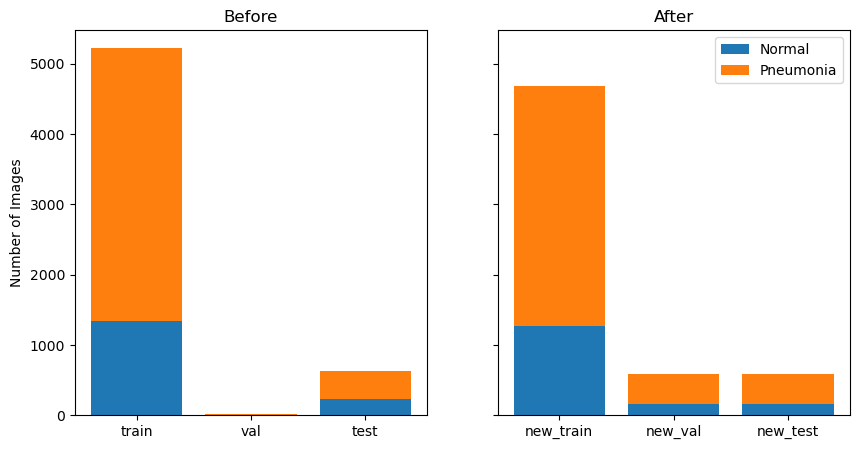

In [24]:
# Define directory
data_dir = "data/chest_xray"

# Function to count images
def count_images(directory):
    normal_count = len(os.listdir(os.path.join(directory, 'NORMAL')))
    pneumonia_count = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    return normal_count, pneumonia_count

# Function to collect data
def collect_data(datasets, base_dir):
    data = {
        'Dataset': [],
        'Normal': [],
        'Pneumonia': [],
        'Total': []
    }
    for dataset in datasets:
        normal, pneumonia = count_images(os.path.join(base_dir, dataset))
        data['Dataset'].append(dataset)
        data['Normal'].append(normal)
        data['Pneumonia'].append(pneumonia)
        data['Total'].append(normal + pneumonia)
    return pd.DataFrame(data)

# Function to plot data
def plot_data(df):
    df.plot(kind='bar', x='Dataset', y=['Normal', 'Pneumonia'], stacked=True)

# Collecting pre and post data
pre_datasets = ['train', 'val', 'test']
post_datasets = ['new_train', 'new_val', 'new_test']

pre_data_df = collect_data(pre_datasets, data_dir)
post_data_df = collect_data(post_datasets, data_dir)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax[0].bar(pre_data_df['Dataset'], pre_data_df['Normal'], label='Normal')
ax[0].bar(pre_data_df['Dataset'], pre_data_df['Pneumonia'], bottom=pre_data_df['Normal'], label='Pneumonia')
ax[0].set_ylabel('Number of Images')
ax[0].set_title('Before')
ax[1].bar(post_data_df['Dataset'], post_data_df['Normal'], label='Normal')
ax[1].bar(post_data_df['Dataset'], post_data_df['Pneumonia'], bottom=post_data_df['Normal'], label='Pneumonia')
ax[1].set_title('After')
plt.legend()

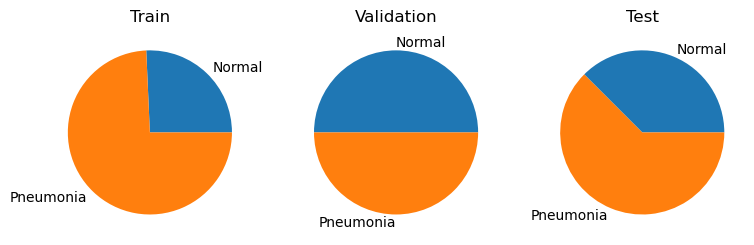

In [42]:
pre_data_df['norm_rate']=round((pre_data_df['Normal']/pre_data_df['Total'])*100,2)
pre_data_df['pneu_rate']=round((pre_data_df['Pneumonia']/pre_data_df['Total'])*100,2)
fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].pie(list(pre_data_df.iloc[0,4:6]), labels=['Normal','Pneumonia'])
ax[0].set_title('Train')
ax[1].pie(list(pre_data_df.iloc[1,4:6]), labels=['Normal','Pneumonia'])
ax[1].set_title('Validation')
ax[2].pie(list(pre_data_df.iloc[2,4:6]), labels=['Normal','Pneumonia'])
ax[2].set_title('Test')
plt.show()

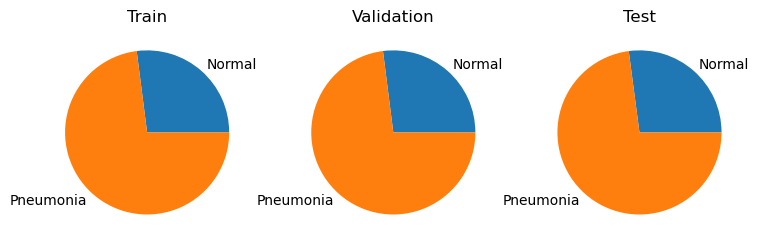

In [43]:
post_data_df['norm_rate']=round((post_data_df['Normal']/post_data_df['Total'])*100,2)
post_data_df['pneu_rate']=round((post_data_df['Pneumonia']/post_data_df['Total'])*100,2)
fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].pie(list(post_data_df.iloc[0,4:6]), labels=['Normal','Pneumonia'])
ax[0].set_title('Train')
ax[1].pie(list(post_data_df.iloc[1,4:6]), labels=['Normal','Pneumonia'])
ax[1].set_title('Validation')
ax[2].pie(list(post_data_df.iloc[2,4:6]), labels=['Normal','Pneumonia'])
ax[2].set_title('Test')
plt.show()

Text(0.5, 1.0, 'After')

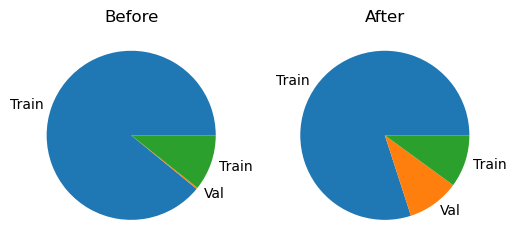

In [49]:
pre_data_df['total_rate']= round((pre_data_df['Total']/pre_data_df['Total'].sum())*100,2)
post_data_df['total_rate']= round((post_data_df['Total']/post_data_df['Total'].sum())*100,2)
list(pre_data_df['total_rate'])

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].pie(list(pre_data_df['total_rate']), labels=['Train','Val', 'Train'])
ax[0].set_title('Before')
ax[1].pie(list(post_data_df['total_rate']), labels=['Train','Val', 'Train'])
ax[1].set_title('After')



In [35]:
pre_train_df = pre_data_df.loc[pre_data_df['Dataset']=='train']
pre_train = [pre_train_df['norm_rate'][0],pre_train_df['pneu_rate'][0]]
pre_train

[25.71, 74.29]

In [ ]:
pre_train = list(pre_data_df.iloc[0,4:6])
pre_val = list(pre_data_df.iloc[1,4:6])
pre_test = list(pre_data_df.iloc[2,4:6])

In [36]:
list(pre_data_df.iloc[0,4:6])

[25.71, 74.29]

In [ ]:
# After
# Training: 3418 to 1266, ratio: 73-27
# Validation: 428 to 159, ratio: 73-27
# Testing: 427 to 159, ratio: 73-27
# Train-Val-Test ratio total: 4684-587-585  percent: 80-10-10